# **Data preprocessing**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sys import path
path.append('../../heartview/')
from heartview.pipeline import ECG
from scipy.fft import fft, fftfreq

## **Load and check data**

In [ ]:
data_dir = '../data/raw/'
output_dir = '../data/preprocessed/'
fs_ecg = 1024
fs_eda = 4
condition = 'neutral'
person = 'YW'
session = 'NY'

# Read data
df_ecg = pd.read_csv(data_dir + f'{session}_{condition}_Session1_ECG_{person}_Calibrated_SD.csv', skiprows=1)
df_eda = pd.read_csv(data_dir + f'{session}_{condition}_Session1_EDA_{person}_Calibrated_SD.csv', skiprows=1)
# df_ecg = pd.read_csv(data_dir + f'{session}_Session1_ECG_{person}_Calibrated_SD.csv', skiprows=1)
# df_eda = pd.read_csv(data_dir + f'{session}_Session1_EDA_{person}_Calibrated_SD.csv', skiprows=1)
#df_eda = pd.read_csv(data_dir + 'YW_test_Session4_EDA_NN_gel.csv', skiprows=1)
output_filename_ecg = f'{session}_{condition}_ECG_{person}_preprocessed.csv'
output_filename_eda = f'{session}_{condition}_EDA_{person}_preprocessed.csv'
#output_filename_ecg = f'{session}_ECG_{person}_preprocessed.csv'
#output_filename_eda = f'{session}_EDA_{person}_preprocessed.csv'

In [215]:
df_ecg

,ECG_NY_Timestamp_Unix_CAL,ECG_NY_Accel_LN_X_CAL,ECG_NY_Accel_LN_Y_CAL,ECG_NY_Accel_LN_Z_CAL,ECG_NY_ECG_EMG_Status1_CAL,ECG_NY_ECG_EMG_Status2_CAL,ECG_NY_ECG_LA-RA_24BIT_CAL,ECG_NY_ECG_LL-LA_24BIT_CAL,ECG_NY_ECG_LL-RA_24BIT_CAL,ECG_NY_ECG_Vx-RL_24BIT_CAL,ECG_NY_Pressure_BMP180_CAL,ECG_NY_Temperature_BMP180_CAL,Unnamed: 12
0,ms,m/(s^2),m/(s^2),m/(s^2),no_units,no_units,mV,mV,mV,mV,kPa,Degrees Celsius,NaN
1,1.732048234796875E12,-2.4457831325301207,9.048192771084338,4.795180722891566,128.0,128.0,-5.723933067790636,-599.2761390538382,-605.0000721216288,-605.0000721216288,100.84457965885704,29.801413483997436,NaN
2,1.7320482348027344E12,-2.5421686746987953,9.036144578313253,4.783132530120482,128.0,128.0,-5.721769418927362,-599.2783027027015,-605.0000721216288,-605.0000721216288,100.84457965885704,29.801413483997436,NaN
3,1.732048234803711E12,-2.4096385542168677,9.060240963855422,4.819277108433735,128.0,128.0,-5.731505838812094,-599.2685662828168,-605.0000721216288,-605.0000721216288,100.84457965885704,29.801413483997436,NaN
4,1.7320482348046875E12,-2.397590361445783,9.060240963855422,4.819277108433735,128.0,128.0,-5.725375500366152,-599.2746966212627,-605.0000721216288,-605.0000721216288,100.84457965885704,29.801413483997436,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
630419,1732048852761.71875,-3.481928,9.46988,-2.674699,128.0,128.0,-6.765369,-598.234703,-605.000072,-605.000072,100.86654,32.595236,NaN
630420,1732048852762.695312,-3.554217,9.39759,-2.662651,128.0,128.0,-6.747339,-598.252733,-605.000072,-605.000072,100.86654,32.595236,NaN
630421,1732048852763.672119,-3.746988,9.349398,-2.614458,128.0,128.0,-6.742651,-598.257421,-605.000072,-605.000072,100.86654,32.595236,NaN
630422,1732048852764.648438,-4.0,9.337349,-2.481928,128.0,128.0,-6.775827,-598.224245,-605.000072,-605.000072,100.86654,32.595236,NaN


In [ ]:
# Remove unnecessary columns
unnamed_cols_ecg = [col for col in df_ecg.columns if col.startswith('Unnamed')]
unnamed_cols_eda = [col for col in df_eda.columns if col.startswith('Unnamed')]
print(unnamed_cols_ecg, unnamed_cols_eda)

In [217]:
# Rename columns
df_ecg = df_ecg.iloc[1:, :].drop(columns=unnamed_cols_ecg).reset_index(drop=True).rename(columns={
        f'ECG_{person}_Timestamp_Unix_CAL': 'timestamp', 
        f'ECG_{person}_Accel_LN_X_CAL': 'acc_x',
        f'ECG_{person}_Accel_LN_Y_CAL': 'acc_y',
        f'ECG_{person}_Accel_LN_Z_CAL': 'acc_z',
        f'ECG_{person}_ECG_EMG_Status1_CAL': 'ecg_emg_status1',
        f'ECG_{person}_ECG_EMG_Status2_CAL': 'ecg_emg_status2',
        f'ECG_{person}_ECG_LA-RA_24BIT_CAL': 'ecg_la_ra', 
        f'ECG_{person}_ECG_LL-LA_24BIT_CAL': 'ecg_ll_la', 
        f'ECG_{person}_ECG_LL-RA_24BIT_CAL': 'ecg_ll_ra',
        f'ECG_{person}_ECG_Vx-RL_24BIT_CAL': 'ecg_vx_rl',
        f'ECG_{person}_Gyro_X_CAL': 'gyro_x',
        f'ECG_{person}_Gyro_Y_CAL': 'gyro_y',
        f'ECG_{person}_Gyro_Z_CAL': 'gyro_z',
        f'ECG_{person}_Pressure_BMP180_CAL': 'pressure',
        f'ECG_{person}_Temperature_BMP180_CAL': 'temperature'
    })
df_ecg

,timestamp,acc_x,acc_y,acc_z,ecg_emg_status1,ecg_emg_status2,ecg_la_ra,ecg_ll_la,ecg_ll_ra,ecg_vx_rl,pressure,temperature
0,1.732048234796875E12,-2.4457831325301207,9.048192771084338,4.795180722891566,128.0,128.0,-5.723933067790636,-599.2761390538382,-605.0000721216288,-605.0000721216288,100.84457965885704,29.801413483997436
1,1.7320482348027344E12,-2.5421686746987953,9.036144578313253,4.783132530120482,128.0,128.0,-5.721769418927362,-599.2783027027015,-605.0000721216288,-605.0000721216288,100.84457965885704,29.801413483997436
2,1.732048234803711E12,-2.4096385542168677,9.060240963855422,4.819277108433735,128.0,128.0,-5.731505838812094,-599.2685662828168,-605.0000721216288,-605.0000721216288,100.84457965885704,29.801413483997436
3,1.7320482348046875E12,-2.397590361445783,9.060240963855422,4.819277108433735,128.0,128.0,-5.725375500366152,-599.2746966212627,-605.0000721216288,-605.0000721216288,100.84457965885704,29.801413483997436
4,1.732048234805664E12,-2.3855421686746987,9.036144578313253,4.807228915662651,128.0,128.0,-5.716720904913057,-599.2833512167158,-605.0000721216288,-605.0000721216288,100.84898049093933,29.801413483997436
...,...,...,...,...,...,...,...,...,...,...,...,...
630418,1732048852761.71875,-3.481928,9.46988,-2.674699,128.0,128.0,-6.765369,-598.234703,-605.000072,-605.000072,100.86654,32.595236
630419,1732048852762.695312,-3.554217,9.39759,-2.662651,128.0,128.0,-6.747339,-598.252733,-605.000072,-605.000072,100.86654,32.595236
630420,1732048852763.672119,-3.746988,9.349398,-2.614458,128.0,128.0,-6.742651,-598.257421,-605.000072,-605.000072,100.86654,32.595236
630421,1732048852764.648438,-4.0,9.337349,-2.481928,128.0,128.0,-6.775827,-598.224245,-605.000072,-605.000072,100.86654,32.595236


In [225]:
# Rename columns
df_eda = df_eda.iloc[1:, :].drop(columns=unnamed_cols_eda).reset_index(drop=True).rename(columns={
        f'EDA_{person}_Timestamp_Unix_CAL': 'timestamp', 
        f'EDA_{person}_Accel_LN_X_CAL': 'acc_x',
        f'EDA_{person}_Accel_LN_Y_CAL': 'acc_y',
        f'EDA_{person}_Accel_LN_Z_CAL': 'acc_z',
        f'EDA_{person}_GSR_Range_CAL': 'gsr_range',
        f'EDA_{person}_GSR_Skin_Conductance_CAL': 'gsr_skin_conductance',
        f'EDA_{person}_GSR_Skin_Resistance_CAL': 'gsr_skin_resistance',
        f'EDA_{person}_Gyro_X_CAL': 'gyro_x',
        f'EDA_{person}_Gyro_Y_CAL': 'gyro_y',
        f'EDA_{person}_Gyro_Z_CAL': 'gyro_z',
        f'EDA_{person}_PPG_A13_CAL': 'ppg',
        f'EDA_{person}_Pressure_BMP180_CAL': 'pressure',
        f'EDA_{person}_Temperature_BMP180_CAL': 'temperature'
    })
df_eda

,timestamp,acc_x,acc_y,acc_z,gsr_range,gsr_skin_conductance,gsr_skin_resistance,ppg,pressure,temperature
0,1.7320482333583984E12,-1.4457831325301205,-2.626506024096386,9.46987951807229,1.0,2.504116092966267,399.34250764526,1613.186813186813,100.90476534284176,27.78484804047128
1,1.7320482336083984E12,-1.493975903614458,-2.9036144578313254,9.578313253012048,1.0,2.504116092966267,399.34250764526,1469.5970695970695,100.90647585756616,27.790853518171815
2,1.7320482338583984E12,-1.2771084337349399,-2.710843373493976,9.433734939759036,1.0,2.504116092966267,399.34250764526,1419.047619047619,100.90501444772039,27.790853518171815
3,1.7320482341083984E12,-1.3253012048192772,-2.7228915662650603,9.3855421686747,1.0,2.504116092966267,399.34250764526,1400.0,100.90501444772039,27.790853518171815
4,1.7320482343583984E12,-1.2650602409638554,-2.734939759036145,9.313253012048193,1.0,2.504116092966267,399.34250764526,1400.7326007326005,100.90355303806273,27.790853518171815
...,...,...,...,...,...,...,...,...,...,...
2480,1.7320488533583984E12,1.1566265060240966,-1.5783132530120483,10.012048192771084,0.0,22.069141472126546,45.3121387283237,1284.9816849816848,100.91965342833355,28.474223784215724
2481,1.7320488536083984E12,0.963855421686747,-1.602409638554217,9.734939759036145,0.0,22.03269367448472,45.38709677419355,1308.4249084249084,100.92476013193708,28.49217394261324
2482,1.7320488538583984E12,0.8795180722891567,-1.5180722891566265,9.867469879518072,0.0,21.996245876842888,45.46230323115162,1298.168498168498,100.92622378608323,28.49217394261324
2483,1.7320488541083984E12,0.7349397590361446,-1.710843373493976,9.048192771084338,0.0,21.923350281559234,45.61346633416459,1222.7106227106226,100.92281932833023,28.480207358216386


In [ ]:
#df_eda = df_eda.rename(columns={f'EDA_{person}_TimestampSync_Unix_CAL': 'timestamp'})

In [ ]:
# Convert to datetime
df_ecg = df_ecg.astype({col: float for col in df_ecg.columns if col != 'timestamp'})
try:
    df_ecg['timestamp'] = pd.to_datetime(df_ecg['timestamp'].astype(float), unit='ms').dt.tz_localize('UTC').dt.tz_convert('America/New_York')
except ValueError:
    df_ecg['timestamp'] = pd.to_datetime(df_ecg['timestamp'])

df_eda = df_eda.astype(float)
df_eda['timestamp'] = pd.to_datetime(df_eda['timestamp'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('America/New_York')

In [232]:
# df_eda = df_eda.astype(float)
# df_eda['timestamp'] = pd.to_datetime(df_eda['timestamp'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('America/New_York')

Text(0, 0.5, 'mV')

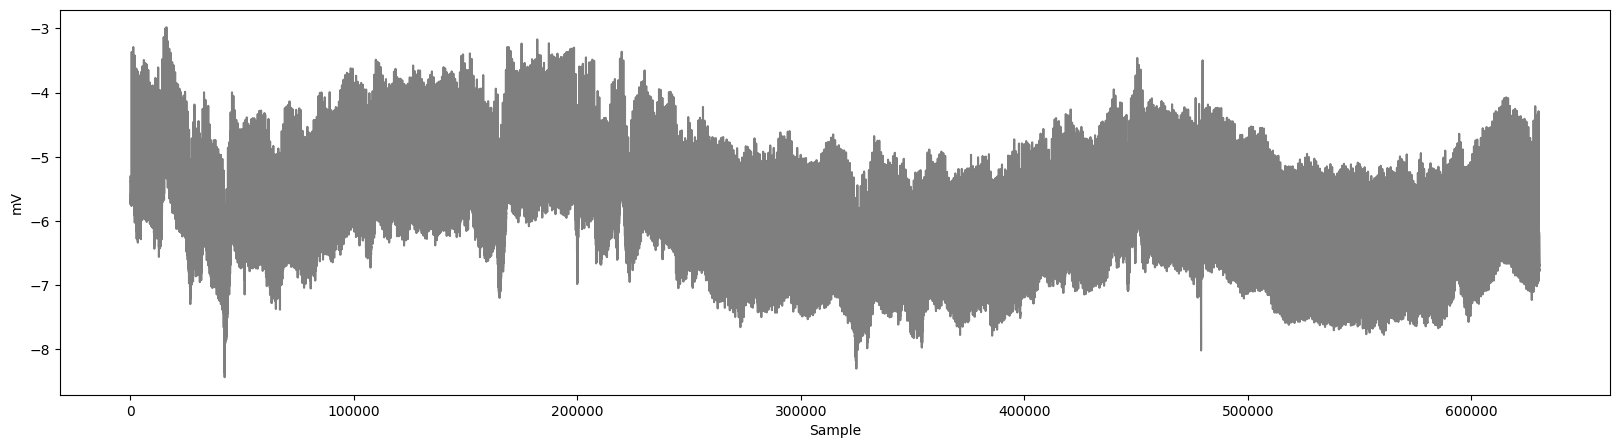

In [220]:
# Check data quality
df_ecg['ecg_la_ra'].iloc[0:].plot(figsize=(20, 5), color='C7')
plt.xlabel('Sample')
plt.ylabel('mV')

Text(0, 0.5, 'uS')

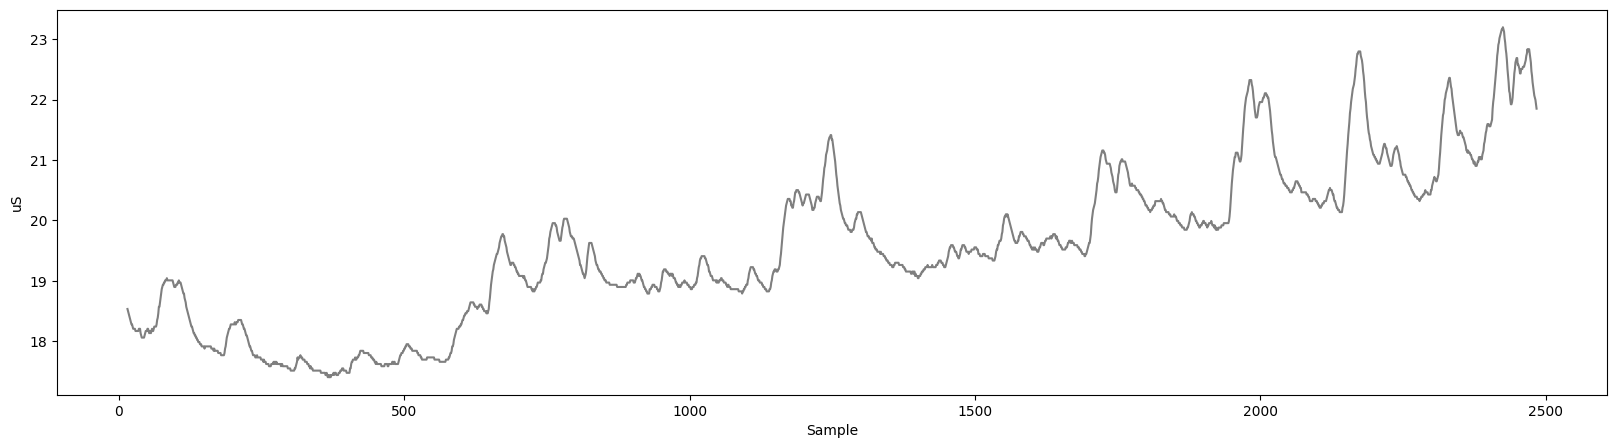

In [227]:
# Check data quality
df_eda['gsr_skin_conductance'].iloc[15:].plot(figsize=(20, 5), color='C7')
plt.xlabel('Sample')
plt.ylabel('uS')

In [ ]:
# Re-sample to reduce sampling frequency
# df_eda_resampled = df_eda[::16].reset_index(drop=True)
# df_eda = df_eda_resampled

In [222]:
df_eda = df_eda[['timestamp', 'gsr_skin_conductance', 'acc_x', 'acc_y', 'acc_z', 'temperature']]
df_eda.to_csv(output_dir + output_filename_eda, index=False)

## **Smoothen the signals**

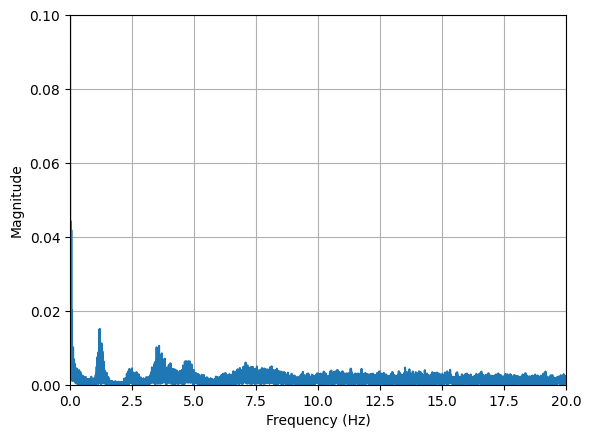

In [144]:
# Check frequency bands
N = len(df_ecg['ecg_la_ra'])
T = 1.0 / fs_ecg
# sample spacing
yf = fft(df_ecg['ecg_la_ra'])
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlim([0, 20])
plt.ylim([0, 0.1])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.show()

Text(0, 0.5, 'mV')

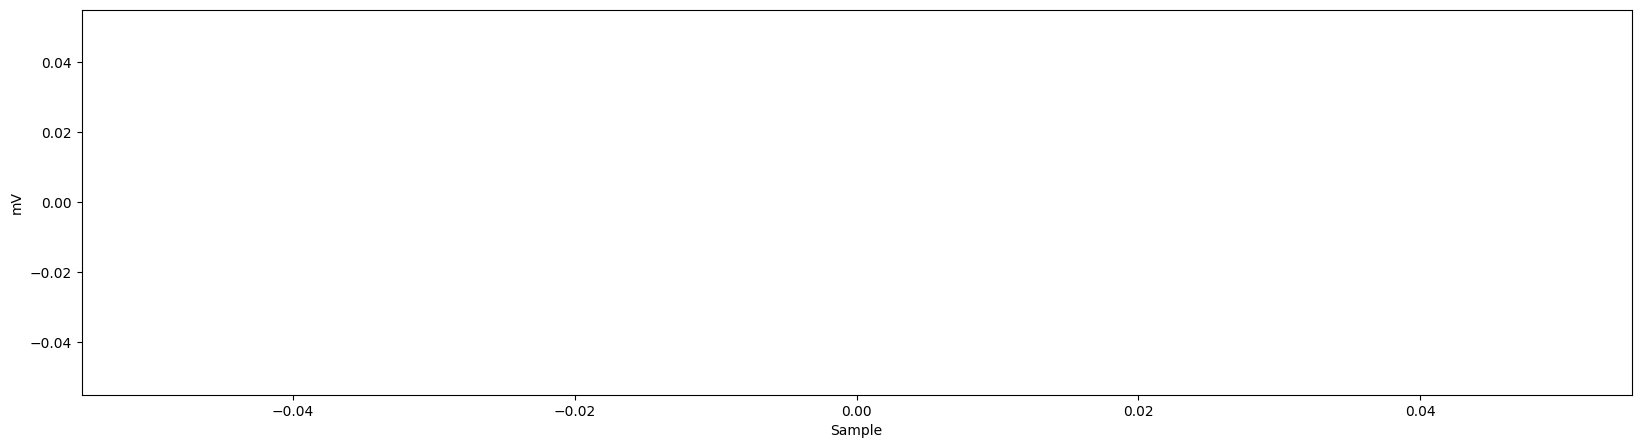

In [145]:
# Filter the ECG signal
Filter = ECG.Filters(fs=fs_ecg)
df_ecg['ecg_filtered'] = Filter.filter_signal(df_ecg['ecg_la_ra'], lowcut=1, highcut=10)
df_ecg['ecg_filtered'].iloc[1700000:1740000].plot(figsize=(20, 5), color='gray')
plt.xlabel('Sample')
plt.ylabel('mV')

In [89]:
# Detect R-peaks
BeatDetector = ECG.BeatDetectors(fs=fs_ecg, preprocessed=True)
ecg_beats = BeatDetector.manikandan(signal=df_ecg['ecg_filtered'], adaptive_threshold=True)
df_ecg['peak'] = 0
df_ecg.loc[ecg_beats, 'peak'] = 1

KeyError: 'peak'

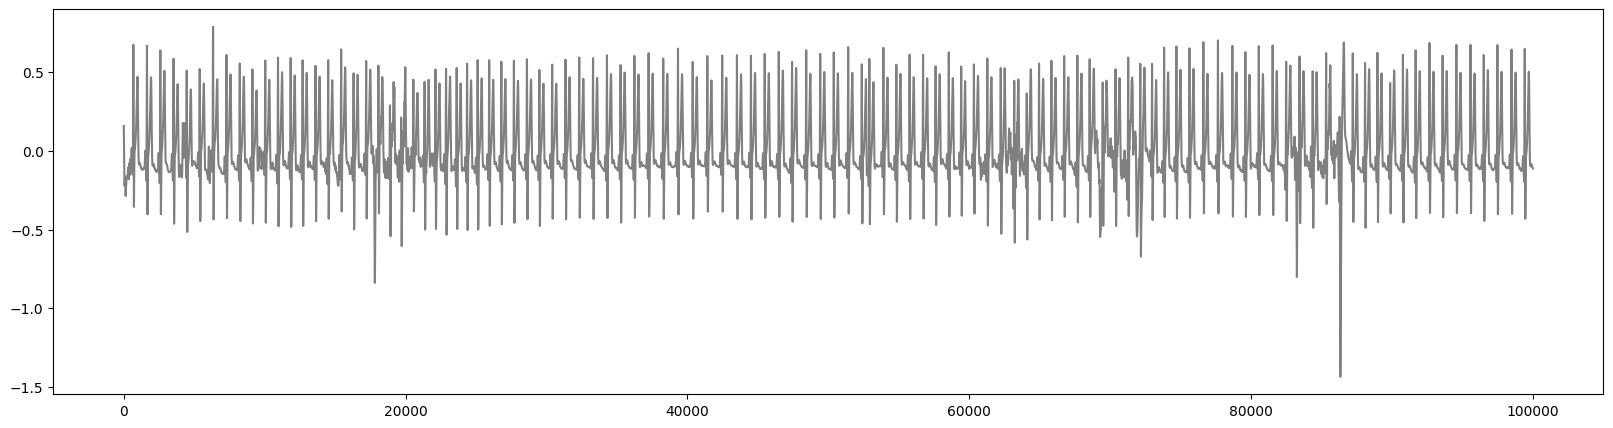

In [110]:
# Check the detected R-peaks
fig, ax = plt.subplots(figsize=(20, 5))
df_plot = df_ecg.iloc[0:100000]
ax.plot(df_plot['ecg_filtered'], color='gray')
ax.scatter(df_plot[df_plot['peak'] == 1].index, df_plot[df_plot['peak'] == 1]['ecg_filtered'], color='red', label='R-peak')
plt.xlabel('Sample')
plt.ylabel('mV')
plt.legend()

In [200]:
df_ecg = df_ecg[['timestamp', 'ecg_filtered', 'peak', 'acc_x', 'acc_y', 'acc_z', 'temperature']]
df_ecg.to_csv(output_dir + output_filename_ecg, index=False)